In [1]:
import numpy as np
from numpy import random
import copy 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap
from collections import Counter

import statistics
from pylab import rcParams
from random import sample

2 main distributions:
number of voters per cluster: e.g. (1000,1000,750,500,200,200,100,100,100)
number of votes per project: e.g. (7000,6500,6000,4500,4000,3000,2000,2000,1500)

2 sub distributions:
number of approvals per voter: based on first two distributions
number of projects in a cluster vs cluster size: e.g.



In [2]:
def generate_ballot(m, p=0.5):
    return (random.rand(m)+(p-0.5)).round().astype(int)

class Cluster():
    def __init__(self, m, n, permutation_rate=0.1, p=0.5):
        self.m = m
        m = int(m * 0.95)
        self.n = n
        self.permutation_rate = permutation_rate
        self._index_map = np.array(sample(range(self.m), m))
        self._mean = generate_ballot(m, p)
        self.__create_n_voter_ballots(m)

        self._mean, tmp = np.zeros(self.m), self._mean
        self._mean[self._index_map] = tmp
        
    def __create_n_voter_ballots(self, m):
        self._ballots = np.zeros((self.n, self.m))
        for i in range(self.n):
            self._ballots[i,self._index_map] = self.__permutate_ballot(m)
        
    def __permutate_ballot(self, m):
        # point permutate the ballot up to 10 times
        new_ballot = copy.copy(self._mean)
        for _ in range(random.randint(self.permutation_rate*m+1)):
            new_ballot[random.randint(m)] = 1 - new_ballot[random.randint(m)]
            
        return new_ballot
    
    @property
    def ballots(self):
        return self._ballots
    
    @property
    def cluster_ballot(self):
        return self._mean
    
    def __repr__(self):
        return str(self._ballots)
    
    def statistics(self):
        rcParams['figure.figsize'] = 7, 4
        rcParams['figure.dpi'] = 75
        rcParams.update({'font.size': 10})
        print(f"Probability that a voter votes the same for one project compared to the cluster ballot = {1-np.mean(np.abs(self._ballots-self._mean))}")
        x,y = np.unique(self._ballots, return_counts=True, axis=0)
        print(f"Number of unique ballets in this cluster = {len(x)}")
        print(f"Number of voters that vote the cluster ballot = {max(y)}")
        plt.plot(*np.unique(np.abs(self._ballots - self._mean).sum(1), return_counts=True), '-o')
        plt.xlabel("difference between voter ballot and cluster ballot")
        plt.ylabel("number of voters")
        plt.show()
        plt.plot(self._mean*100, 'o',label="cluster ballot")
        plt.plot(self._ballots.mean(0)*100,'x',label="voters")
        plt.legend()
        plt.xlim(0,self.m)
        plt.xlabel("Projects")
        plt.ylabel("Change of approving a project(%)")
        plt.show()
        
    

In [3]:
n_clusters = 10
n_voters = 500
clusters = [Cluster(100,n_voters,1.5,0.15) for _ in range(n_clusters)]
target = np.reshape([[i]*n_voters for i in range(n_clusters)], (-1))

data = np.vstack([x.ballots for x in clusters])

Probability that a voter votes the same for one project compared to the cluster ballot = 0.7300800000000001
Number of unique ballets in this cluster = 493
Number of voters that vote the cluster ballot = 8


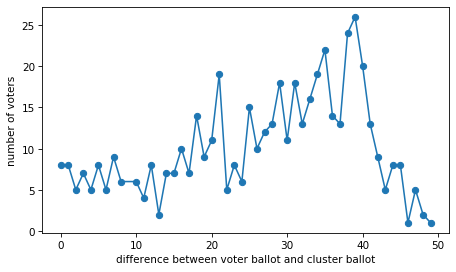

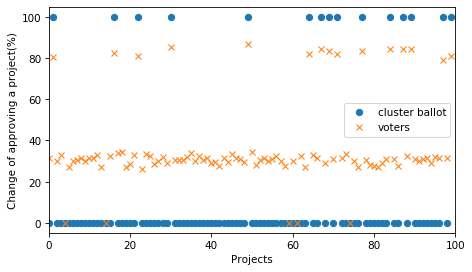

In [4]:
clusters[0].statistics()

In [5]:
k = KMeans(n_clusters).fit_predict(data)
acc = []
for i in range(n_clusters):
    one_cluster = k[i*n_voters: (i+1)*n_voters]
    occurence_count = Counter(one_cluster)
    acc.append(np.mean(one_cluster == occurence_count.most_common(1)[0][0]))

print(f"acc for each cluster: {acc} \nAvg acc: {np.mean(acc):.3f}")

acc for each cluster: [0.95, 0.98, 0.948, 0.952, 0.952, 0.962, 0.944, 0.984, 0.926, 0.938] 
Avg acc: 0.954


In [6]:
reducer = umap.UMAP(n_components=2, n_neighbors=100, metric='manhattan')
reducer.fit(data)
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(5000, 2)

In [7]:
kmeans = KMeans(n_clusters).fit(embedding)
k = kmeans.labels_
# mean = reducer.inverse_transform(kmeans.cluster_centers_)

acc = []
for i in range(n_clusters):
    one_cluster = k[i*n_voters: (i+1)*n_voters]
    occurence_count = Counter(one_cluster)
    acc.append(np.mean(one_cluster == occurence_count.most_common(1)[0][0]))

print(f"acc for each cluster: {acc} \nAvg acc: {np.mean(acc):.3f}")

acc for each cluster: [0.936, 0.96, 0.944, 0.936, 0.93, 0.952, 0.936, 0.968, 0.922, 0.952] 
Avg acc: 0.944


Text(0.5, 1.0, 'UMAP projection of the dataset')

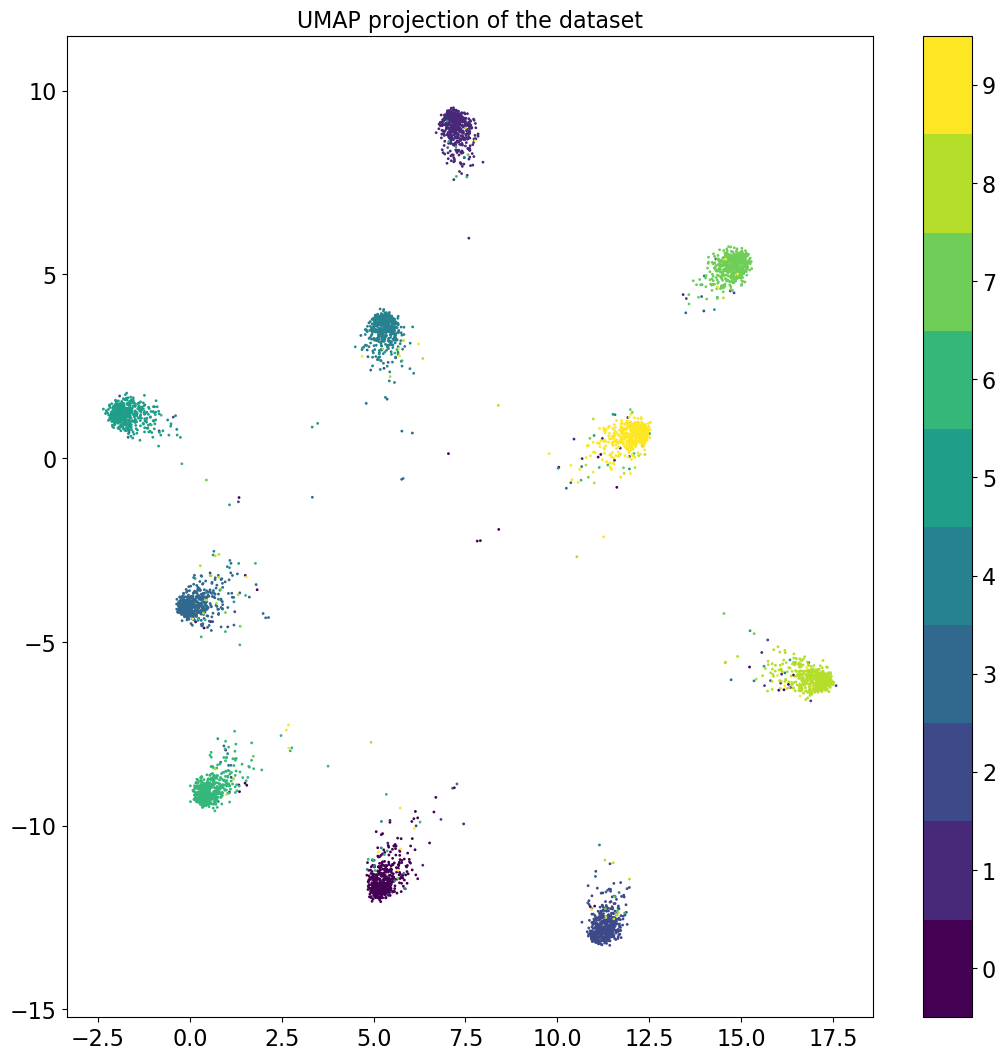

In [8]:
rcParams['figure.figsize'] = 13, 13
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=target, s=1)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(n_clusters+1)-0.5).set_ticks(np.arange(n_clusters))
plt.title('UMAP projection of the dataset', fontsize=16)